# **Interpretability of Neural Networks for model selection**
## Modified gravity (Hu-Sawicki model) vs ΛCDM at the level of the CMB angular power spectrum - $\mathcal{C}^{TT}_{\ell}$ data
### Assess the NN learning process with [explainable AI with Shapley values](https://github.com/shap/shap.git)
### Which features is the NN actually learning when differentiating a primoridal feature template model and ΛCDM?
**Find the documentation [here](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).**

In [1]:
#Import packages
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers.experimental.preprocessing import Normalization
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam

### Read and visualize the data (simulated out of [CLASS](https://github.com/lesgourg/class_public) and the [ESA Planck Archival](https://pla.esac.esa.int/#home))

In [2]:
#Read the data
label = '_FR0_e-6_FRn'
planck_df_LCDM = np.genfromtxt('./simulated_data/TT_polarization/ttcls_MoGgrids_noisy_FR0_LCDM.csv', delimiter=',')
planck_df_MoG = np.genfromtxt('./simulated_data/TT_polarization/ttcls_MoGgrids_noisy%s.csv'%label, delimiter=',')
ls_planck = planck_df_LCDM[0]
planck_cls_LCDM = planck_df_LCDM[1:] # Get rid of the first column, i.e. multipole moment \ell
planck_cls_MoG = planck_df_MoG[1:]
ls = planck_df_LCDM[0] #\ells

#Add the model class: 
LCDM_class = np.zeros(len(planck_cls_LCDM))
MoG_class = np.ones(len(planck_cls_MoG))

#Full arrays (+target):
cls_LCDM_class = np.column_stack((planck_cls_LCDM, LCDM_class))
cls_MoG_class = np.column_stack((planck_cls_MoG, MoG_class))

#Full data set (LCDM + MoG)
cls_full_dataset = np.concatenate((planck_cls_LCDM, planck_cls_MoG)) #without the class: x_dataset
dataset_class = np.concatenate((LCDM_class, MoG_class)) #only the class: y_dataset
cls_full_dataset_class = np.concatenate((cls_LCDM_class, cls_MoG_class)) #with the class: xy_dataset

In [3]:
#-----------------------------------------------------------------------------------------------------------------------
#Dls
#-----------------------------------------------------------------------------------------------------------------------
# Create a function for converting the C_ls^TT to Dls Tcmb=2.7255
def Dls(l,CTT):
    Dl = [l[i]*(l[i]+1)*CTT[i]/((2*math.pi)*(2.7255*10**6)**2) for i in range(len(l))]
    return Dl
#-----------------------------------------------------------------------------------------------------------------------

### Z-score normalization of the $\mathcal{C}^{TT}_{\ell}$ data

In [4]:
#-------------------------------------------------------------------------------------------------------------
#Normalization
#-------------------------------------------------------------------------------------------------------------
normalize = Normalization()
normalize.adapt(cls_full_dataset)
normalized_data = normalize(cls_full_dataset)

#Z-SCORE verification
print('var: %.4f' % np.var(normalized_data))
print('mean: %.4f' % np.mean(normalized_data))

var: 1.0000
mean: -0.0000


### Training the neural networks

In [5]:
#Train_test_split
from sklearn.model_selection import train_test_split
normalized_data_numpy = normalized_data.numpy()
X_train, X_test, y_train, y_test = train_test_split(normalized_data_numpy, dataset_class, test_size=0.3, random_state=42)
#Training and validation split with fixed random seed
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
#Redefine the model's architecture to display the input layer: (functional API)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

inputs = Input(shape=(len(normalized_data[0]),), name='input_layer') #shape=X_train.shape[1],
hidden_layer = Dense(32, activation='relu', name='hidden_layer')(inputs)
dropout_layer = Dropout(rate=0.2, name='dropout_layer')(hidden_layer)
outputs = Dense(1, activation='sigmoid', name='output_layer')(dropout_layer)

#Create the model
model = Model(inputs=inputs, outputs=outputs, name='Angular_PS_NN')

#Model details
model.summary()

Model: "Angular_PS_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 83)]              0         
                                                                 
 hidden_layer (Dense)        (None, 32)                2688      
                                                                 
 dropout_layer (Dropout)     (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 2721 (10.63 KB)
Trainable params: 2721 (10.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
#-----------------------------------------------------------------------------------------------------------
#Training the NN
#-----------------------------------------------------------------------------------------------------------
model.reset_states()
#Compile model:
model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

#Training:
History = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/1000
35/35 [==============================] - 1s 9ms/step - loss: 0.8455 - accuracy: 0.4821 - val_loss: 0.7091 - val_accuracy: 0.5214
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.7818 - accuracy: 0.4768 - val_loss: 0.7003 - val_accuracy: 0.5071
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.7450 - accuracy: 0.4991 - val_loss: 0.6993 - val_accuracy: 0.4821
Epoch 4/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.7497 - accuracy: 0.4902 - val_loss: 0.7009 - val_accuracy: 0.4821
Epoch 5/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.7328 - accuracy: 0.4893 - val_loss: 0.7030 - val_accuracy: 0.5071
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.7235 - accuracy: 0.5080 - val_loss: 0.7019 - val_accuracy: 0.4821
Epoch 7/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.7204 - accuracy: 0.5161 - val_loss: 0.7011 - val_accuracy: 0.4929
Epoch 

## Interpretability using [SHAP (SHapley Additive exPlanations)](https://github.com/shap/shap.git)

In [8]:
%%capture
#-----------------------------------------------------------------------------------------------------------
#Interpretability 
#-----------------------------------------------------------------------------------------------------------
import shap
X100 = shap.utils.sample(X_train, 100); #100 instances as the background distribution

# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100);
shap_values = explainer(X_train);

print('SHAP values were succesfully calculated')

### Shapley values and the prectiction (ΛCDM or HS) for each realization:

#### Local Interpretability plots

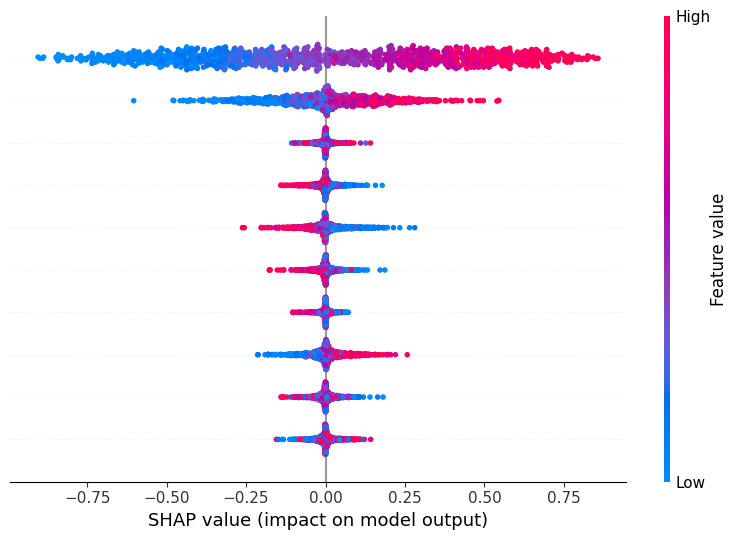

In [9]:
#Summary plot (default by SHAP)
shap.summary_plot(shap_values, X_train, sort=False, max_display=10, plot_type="dot", feature_names=[""] * X_train.shape[1], color_bar=True)

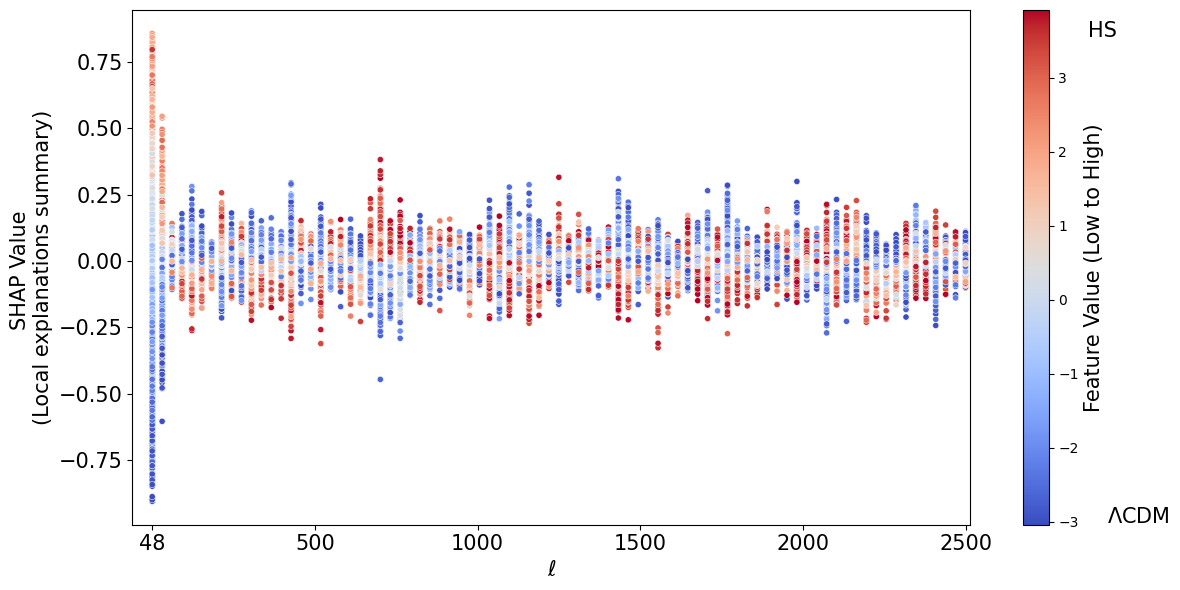

In [10]:
#Customized plot
import seaborn as sns

shap_values_array = shap_values.values  #SHAP values for each feature
feature_data = shap_values.data         #Original feature values
fsize = 15

#Number of features
n_features = shap_values_array.shape[1]

#Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

#Plot SHAP values
for i in range(n_features):
    #Scatter plot: x = SHAP_value, y = feature, color = feature_value
    sns.scatterplot(
        x=np.ones_like(shap_values_array[:, i]) * i,  # SHAP_value for feature i
        y=shap_values_array[:, i], 
        hue=feature_data[:, i],
        palette='coolwarm',
        legend=False,
        s=20,
        ax=ax
    )

num_ticks = 5
x_ticks = np.linspace(ls_planck[0], 2500, num_ticks) 
ax.set_xticks(np.linspace(0, n_features - 1, num_ticks))
ax.set_xticklabels([f"{int(tick)}" for tick in x_ticks], fontsize=fsize)

num_ticks = 6  
x_ticks = np.array([ls_planck[0], 500, 1000, 1500, 2000, 2500])
ax.set_xticks(np.linspace(0, n_features - 1, num_ticks))
ax.set_xticklabels([f"{int(tick)}" for tick in x_ticks], fontsize=fsize)

ax.set_xlim(-2, 82.5)

#Color bar (feature values)
norm = plt.Normalize(vmin=feature_data.min(), vmax=feature_data.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label('Feature Value (Low to High)', fontsize=fsize)
cbar.ax.text(3.1, 3.5, 'HS', ha='center', va='bottom', fontsize=fsize)
cbar.ax.text(4.5, -2.8, '$\Lambda$CDM', ha='center', va='top', fontsize=fsize)

ax.set_ylabel("SHAP Value \n(Local explanations summary)", fontsize=fsize)
ax.tick_params(labelsize=fsize)
ax.set_xlabel('$\ell$', fontsize=fsize)

plt.tight_layout()
plt.savefig('./figures_MoG/Shap_Local_Interpretability_Summary_MG.pdf')

plt.show()

### Global interpretability plots

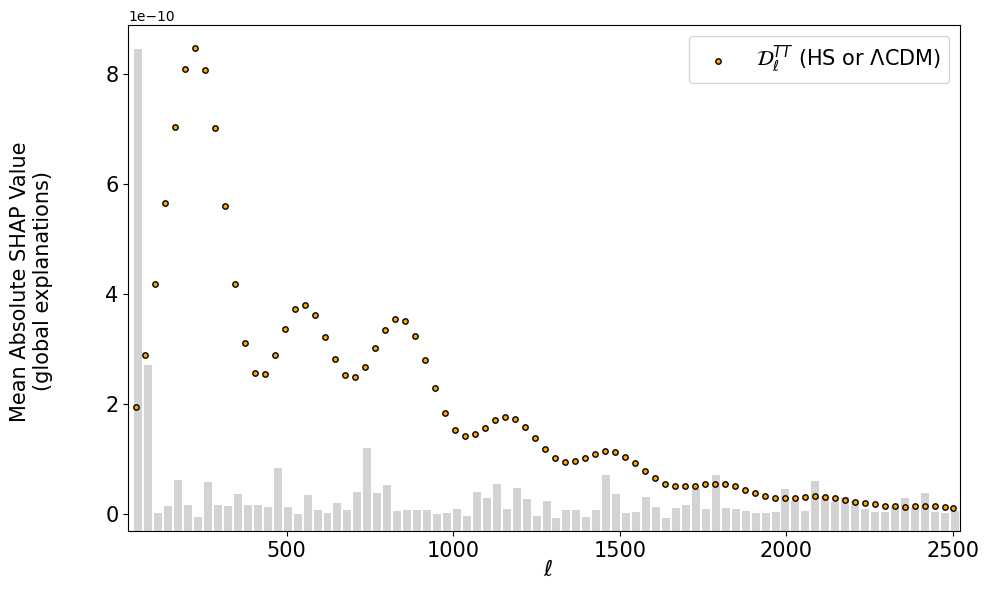

In [11]:
mean_abs_shap_values = np.mean(np.abs(shap_values_array), axis=0)
n_features = shap_values_array.shape[1]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.axis("off")

#Plot 1: vertical bars for global feature importance
ax1 = fig.add_subplot()
ax1.bar(
    range(len(ls_planck)), 
    mean_abs_shap_values[range(len(ls_planck))],
    color='lightgray',  #Set bar color
)

ax1.set_xlim(-1,82.5)
ax1.set_xticks([]) 
ax1.set_yticks([]) 
ax1.set_ylabel('Mean Absolute SHAP Value \n(global explanations) \n \n \n ', fontsize=fsize)
ax1.set_xlabel('\n $\ell$', fontsize=fsize+1)

# PLOT 2: Planck-like data for MG vs LCDM
ax2 = fig.add_subplot(frame_on=False)
ax2.scatter(ls_planck, Dls(ls_planck,planck_df_MoG[1]), s=15, label='$\mathcal{D}^{TT}_{\ell}$ (HS or $\Lambda$CDM)', color='orange', edgecolors='black')
ax2.tick_params(axis='x', labelsize=fsize)
ax2.tick_params(axis='y', labelsize=fsize)
ax2.legend(fontsize=fsize)
ax2.set_xlim(25,2520)

plt.tight_layout()
plt.savefig('./figures_MoG/Shap_Global_Interpretability_Summary_MG.pdf')
plt.show()

### Partial dependence plots 

4/4 [==============================] - 0s 4ms/step


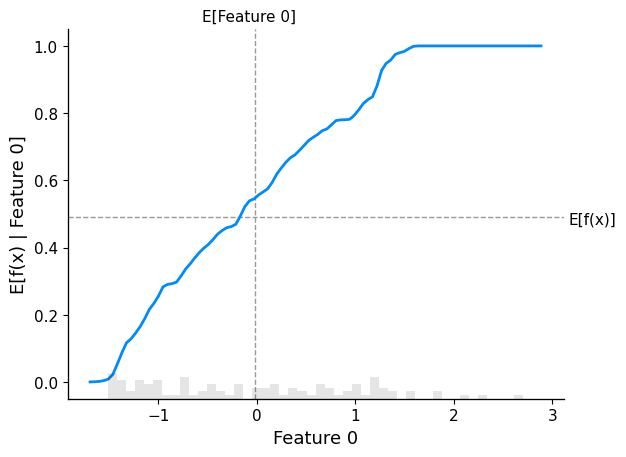

In [12]:
sample_ind = 5

shap.partial_dependence_plot(
    0,
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

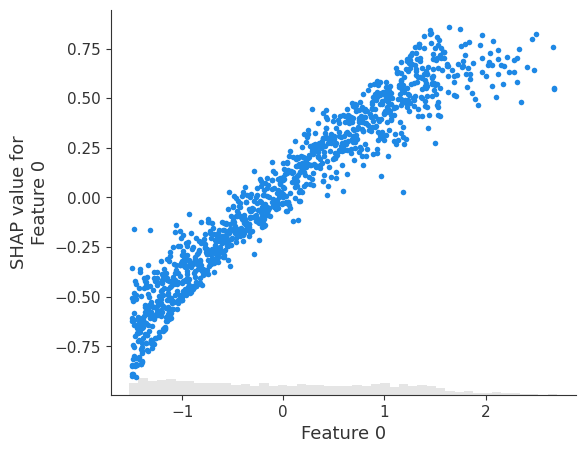

In [13]:
#Example plot: Feature value vs shap value for the first C_l(l=48)
shap.plots.scatter(shap_values[:, 0])

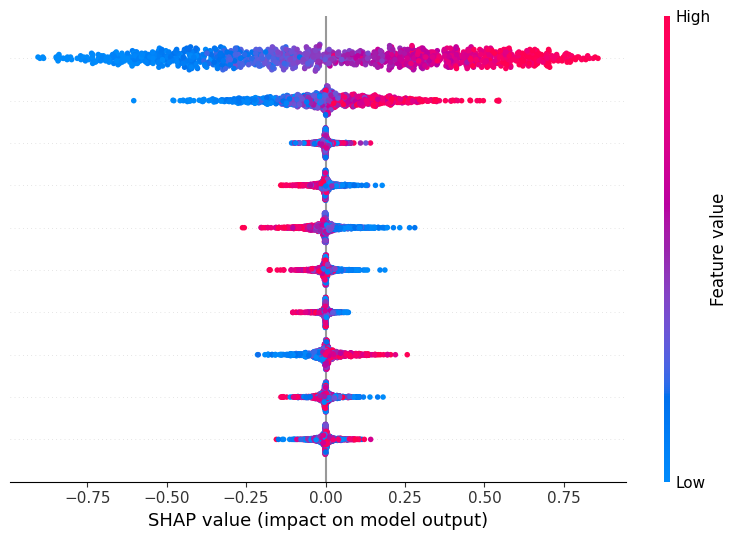

In [14]:
shap.summary_plot(shap_values, X_train, sort=False, max_display=10, plot_type="dot", feature_names=[""] * X_train.shape[1], color_bar=True)

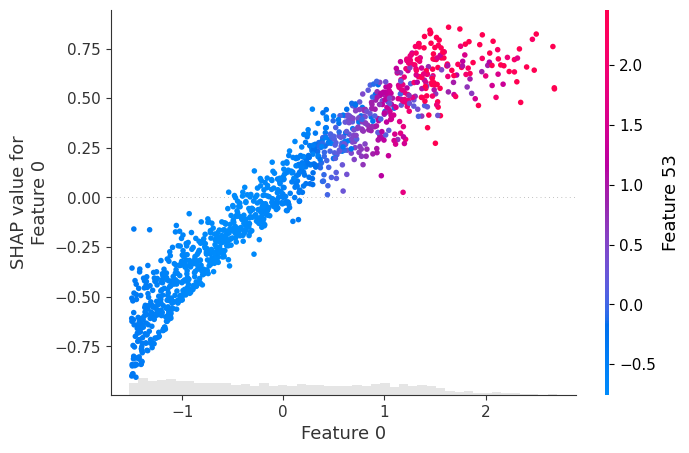

In [15]:
#Partial dependence plotts of crossed features
shap.plots.scatter(shap_values[:, 0], color=shap_values)

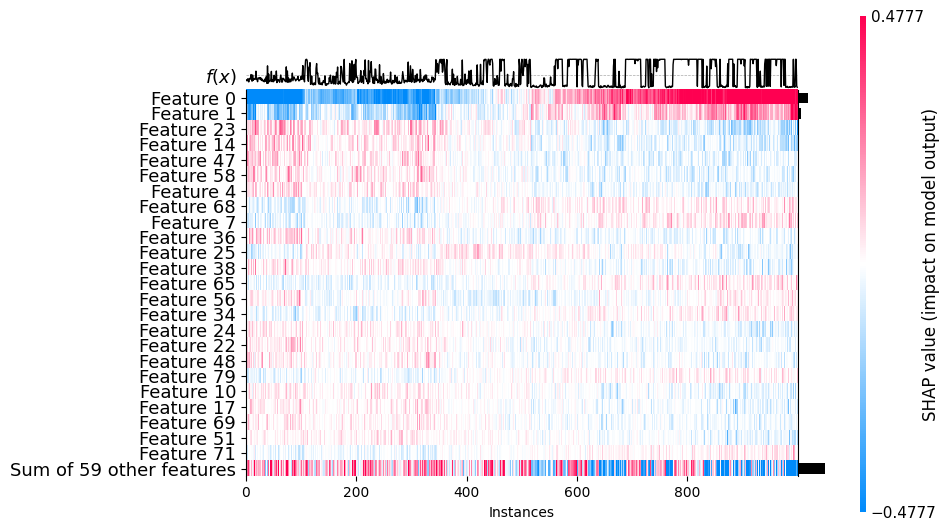

<Axes: xlabel='Instances'>

In [16]:
shap.plots.heatmap(shap_values[:1000], max_display=25)

### Testing the NNs

In [17]:
#Function for the probability of classification as LCDM 
def normFeat(p):
  if 0<p<0.5:
    rr=1-p
  else:
    rr=p
  return rr

#Function for the probability of classification as Feature 
def normLCDM(p):
  if 0<p<0.5:
    rr=p
  else:
    rr=1-p
  return rr

In [18]:
#-----------------------------------------------------------------------------------------------------------
#Test the NN
#-----------------------------------------------------------------------------------------------------------
theory = ['LCDM','FT']

true_model=[]
pred_model=[]
prob_pred_MoG=[]
prob_pred_LCDM=[]
for i in range(len(X_test)):
  X_test_tf = tf.convert_to_tensor([X_test[i]])
  predictions = model.predict(X_test_tf)
  true_model.append(round(y_test[i]))
  pred_model.append(round(predictions[0][0]))
  prob_pred_MoG.append(round(100*normFeat(predictions[0][0]),3))
  prob_pred_LCDM.append(round(100*normLCDM(predictions[0][0]),3))

1/1 [==============================] - 0s 16ms/step


### Performance verification of the NNs

In [19]:
#-----------------------------------------------------------------------------------------------------------
#Performance: correct & incorrect  predictions
#-----------------------------------------------------------------------------------------------------------
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred_model, true_model):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]

print('     ','LCDM','MoG')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM MoG
True  0.5033333333333333 0.39
False 0.10666666666666667 0.0
--------------
Correct prediction:  0.8933333333333333
Wrong prediction  :  0.10666666666666667
